This file implements the testing for this model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from model.model_init import PITGAN

from data_processing.basic_synthetic_dataset import generate_basic_2D
from data_processing.data_transformer import DataTransformer, place_discrete, move_continuous, reverte_continuous

from visualizations.scatter_plots import plot_2D_data
from visualizations.training_loss_plots import plot_losses

from model.model_helpers import get_latent_dims

from evaluation.privacy import compute_TCAP
from evaluation.utility import compute_ROC, compute_CIO, compute_pMSE, compute_CIO_folds
from evaluation.evaluation_helpers import calculate_features

Next we load in the synthetic training data for the basic 2D example and then plot the output

In [2]:
# First we initialize the distribution for the basic example
cats = [0.2, 0.5, 0.3]
cat_names = ['small', 'medium', 'large']
mu = [[0, 0], [2, 2.1], [4.5, 4.6]]
sig = [
    [[0.05, 0], [0, 0.02]],  # Mode1: Much narrower and taller
    [[0.3, 0.15], [0.15, 0.3]],  # Mode2: Wider and more tilted
    [[0.1, -0.08], [-0.08, 0.1]]  # Mode3: Moderate width but with a significant tilt in the opposite direction
]

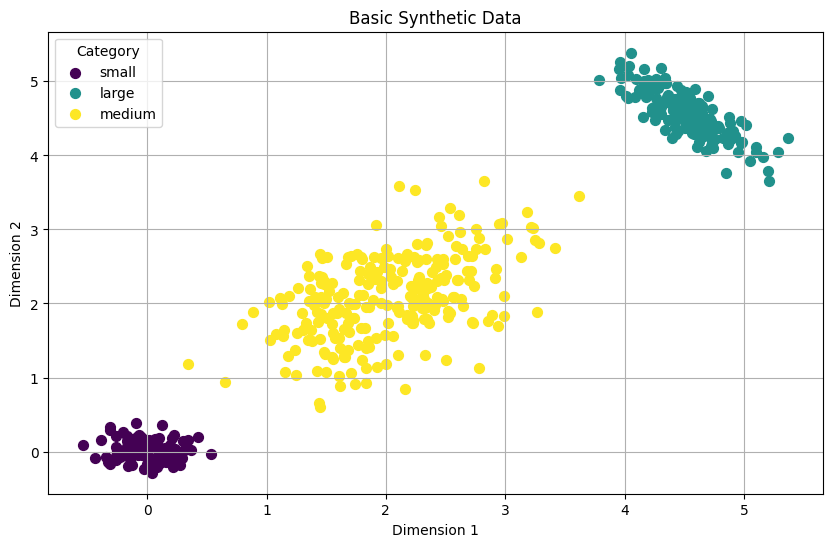

In [3]:
# Draw samples and plot them
plot_examples = generate_basic_2D(cats, cat_names, mu, sig, 500)

plot_2D_data(plot_examples, 'Basic Synthetic Data')

Next we need to apply the transformer to this data

In [4]:
train = generate_basic_2D(cats, cat_names, mu, sig, 500)
train_synth = generate_basic_2D(cats, cat_names, mu, sig, 500)

# Then we train the DataTransformer to learn
basic_transformer = DataTransformer()
basic_transformer.fit(train, ['Category'])

# Store the dimensions of the fitted data, and reorder the continuous data
D_list, C_list = basic_transformer.get_relevant_dimensions()

D_list, C_list

([3], [4, 3])

In [5]:
train = generate_basic_2D(cats, cat_names, mu, sig, 1500)
train_synth = generate_basic_2D(cats, cat_names, mu, sig, 1500)

Next define the model to be used for this simple example

In [16]:
# Initialize the inputs for the model
hidden_dimensions = {
    'dim_e': [128, 64, 32],
    'dim_r': [32, 64, 128],
    'dim_g': [254, 254, 254],
    'dim_c': [254, 254, 254],
}
parameters = {
    'alpha_sup': 1,
    'alpha_grad': 10, # balances gradient pen in critic loss
    'grad_step_autoencoding': 0.001,
    'grad_step_generator': 0.0001,
    'grad_step_critic': 0.001,
    'batch_size': 500,
    'latent_sharpness': 20,
    'critic_steps': 5,
    'R': 5
}

PITGAN_model = PITGAN(1, hidden_dimensions, parameters, basic_transformer)

Next we summarize the model and check if it compiles

In [7]:
# Make sure all of the layers are properly made
PITGAN_model.get_summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_slice_1         │ (None, 3)         │          0 │ encoder_input[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_1        │ (None, 5)         │          0 │ encoder_input[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_2        │ (None, 4)         │          0 │ encoder_input[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_embed_1 (Dense) │ (None, 2)         │          8 │ cat_slice_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_1        │ (None, 4)         │         24 │ mode_slice_1[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_2        │ (None, 3)         │         15 │ mode_slice_2[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_concat        │ (None, 9)         │          0 │ cat_embed_1[0][0… │
│ (Concatenate)       │                   │            │ mode_embed_1[0][… │
│                     │                   │            │ mode_embed_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer1       │ (None, 128)       │      1,280 │ embed_concat[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer2       │ (None, 64)        │      8,256 │ hidden_layer1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer3       │ (None, 32)        │      2,080 │ hidden_layer2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_logits       │ (None, 2)         │         66 │ hidden_layer3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,729 (45.82 KB)

 Trainable params: 11,729 (45.82 KB)

 Non-trainable params: 0 (0.00 B)

None
###################################################################


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_latent        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_1      │ (None, 32)        │         96 │ input_latent[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_2      │ (None, 64)        │      2,112 │ hidden_layer_1[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_3      │ (None, 128)       │      8,320 │ hidden_layer_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_output_1        │ (None, 3)         │        387 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_output_1       │ (None, 5)         │        645 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_output_2       │ (None, 4)         │        516 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_concat       │ (None, 12)        │          0 │ cat_output_1[0][… │
│ (Concatenate)       │                   │            │ mode_output_1[0]… │
│                     │                   │            │ mode_output_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,076 (47.17 KB)

 Trainable params: 12,076 (47.17 KB)

 Non-trainable params: 0 (0.00 B)

None
###################################################################


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_noise         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_scaled        │ (None, 5)         │          0 │ input_noise[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_latent        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_concat        │ (None, 7)         │          0 │ noise_scaled[0][… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_concat_1     │ (None, 9)         │          0 │ input_concat[0][… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_1      │ (None, 254)       │      2,540 │ hidden_concat_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_concat_2     │ (None, 256)       │          0 │ hidden_layer_1[0… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_2      │ (None, 254)       │     65,278 │ hidden_concat_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_concat_3     │ (None, 256)       │          0 │ hidden_layer_2[0… │
│ (Concatenate)       │                   │            │ input_latent[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_3      │ (None, 254)       │     65,278 │ hidden_concat_3[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_logits       │ (None, 12)        │      3,060 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_continuous   │ (None, 2)         │        510 │ hidden_layer_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_concat       │ (None, 14)        │          0 │ output_logits[0]… │
│ (Concatenate)       │                   │            │ output_continuou… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,666 (533.85 KB)

 Trainable params: 136,666 (533.85 KB)

 Non-trainable params: 0 (0.00 B)

None
###################################################################


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_raw           │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_1        │ (None, 5)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_2        │ (None, 4)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_slice_1         │ (None, 3)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_scaled_1 │ (None, 5)         │          0 │ mode_slice_1[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cont_slice_1        │ (None, 1)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_slice_scaled_2 │ (None, 4)         │          0 │ mode_slice_2[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cont_slice_2        │ (None, 1)         │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_slice_scaled_1  │ (None, 3)         │          0 │ cat_slice_1[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_concat_1 │ (None, 6)         │          0 │ mode_slice_scale… │
│ (Concatenate)       │                   │            │ cont_slice_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ continuous_concat_2 │ (None, 5)         │          0 │ mode_slice_scale… │
│ (Concatenate)       │                   │            │ cont_slice_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_embed_1 (Dense) │ (None, 2)         │          8 │ cat_slice_scaled… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_1        │ (None, 5)         │         35 │ continuous_conca… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mode_embed_2        │ (None, 4)         │         24 │ continuous_conca… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_discrete_sli… │ (None, 12)        │          0 │ input_raw[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_latent        │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_concat        │ (None, 25)        │          0 │ cat_embed_1[0][0… │
│ (Concatenate)       │                   │            │ mode_embed_1[0][

 Total params: 137,990 (539.02 KB)

 Trainable params: 137,990 (539.02 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
PITGAN_model.compile()

Next we train the model. This consists of first training the encoder decoder, then the generative network. 

In [17]:
# Train the encoder and decoder network parts
losses_autoencoder = PITGAN_model.fit_autoencoder(train, 100)

---Starting Autoencoder Training
Epoch 0: Reconstruction Loss = 1.1831127405166626
Epoch 1: Reconstruction Loss = 1.1646652221679688
Epoch 2: Reconstruction Loss = 1.1445175409317017
Epoch 3: Reconstruction Loss = 1.12025785446167
Epoch 4: Reconstruction Loss = 1.0930670499801636
Epoch 5: Reconstruction Loss = 1.0612072944641113
Epoch 6: Reconstruction Loss = 1.0248602628707886
Epoch 7: Reconstruction Loss = 0.9856861233711243
Epoch 8: Reconstruction Loss = 0.9437611103057861
Epoch 9: Reconstruction Loss = 0.904196560382843
Epoch 10: Reconstruction Loss = 0.8650093674659729
Epoch 11: Reconstruction Loss = 0.8257843852043152
Epoch 12: Reconstruction Loss = 0.7871912121772766
Epoch 13: Reconstruction Loss = 0.7489551901817322
Epoch 14: Reconstruction Loss = 0.713111937046051
Epoch 15: Reconstruction Loss = 0.681621253490448
Epoch 16: Reconstruction Loss = 0.6572726368904114
Epoch 17: Reconstruction Loss = 0.641172468662262
Epoch 18: Reconstruction Loss = 0.6312469840049744
Epoch 19: Reco

In [8]:
encoder_losses = PITGAN_model.fit_encoder(train, 10)

---Starting Encoder Training
Epoch 0: Encoder Loss = 0.15334786474704742
Epoch 1: Encoder Loss = 0.12041386216878891
Epoch 2: Encoder Loss = 0.08423181623220444
Epoch 3: Encoder Loss = 0.05638130381703377
Epoch 4: Encoder Loss = 0.035438746213912964
Epoch 5: Encoder Loss = 0.022113239392638206
Epoch 6: Encoder Loss = 0.014220505021512508
Epoch 7: Encoder Loss = 0.00967022031545639
Epoch 8: Encoder Loss = 0.007018953561782837
Epoch 9: Encoder Loss = 0.005111789796501398
---Finished Encoder Training


In [7]:
train.head(20)

,Dimension_1,Dimension_2,Category
0,2.547888,2.844183,medium
1,1.690596,1.707771,medium
2,4.624154,4.449771,large
3,2.206995,2.224864,medium
4,2.180376,1.965572,medium
5,1.801758,1.720036,medium
6,3.251327,2.408467,medium
7,2.195990,1.956767,medium
8,0.000294,-0.059171,small
9,5.152481,4.075055,large


In [9]:
Y = PITGAN_model.get_latent(train, True)

Y = pd.DataFrame(Y)

Y.head(25)

,0
0,0.999833
1,0.999833
2,0.999833
3,0.001893
4,0.001893
5,0.005946
6,0.001893
7,0.999833
8,0.760760
9,0.005946


In [7]:
Y = PITGAN_model.get_latent(train, True)

Y = pd.DataFrame(Y)

Y.head(25)

,0
0,0.996231
1,0.996231
2,0.021606
3,0.435813
4,0.435813
5,0.996231
6,0.996231
7,0.021606
8,0.021606
9,0.996231


In [8]:
X_test = [[5, 0, 'medium']]

X_test = pd.DataFrame(X_test, columns=['Dimension_1', 'Dimension_2', 'Category'])

Y = PITGAN_model.get_latent(X_test, True)

Y = pd.DataFrame(Y)

Y.head()

,0
0,0.302883


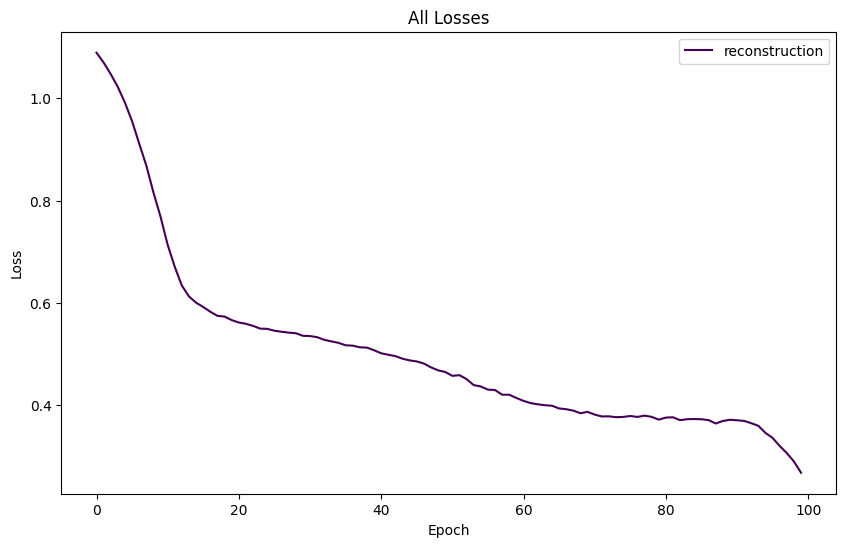

In [38]:
# plot the losses
plot_losses(losses_autoencoder, False)

In [18]:
decoded = PITGAN_model.get_decoded(train)

ROC = compute_ROC(train, decoded, basic_transformer)

ROC

,Variable,ROC
0,Category,0.462250
1,C_1,0.503747
2,C_2,0.167904


In [80]:
discrete_lossses = PITGAN_model.fit_encoder(train, 15)

---Starting Encoder Training
Epoch 0: Encoder Loss = 0.11602126806974411
Epoch 1: Encoder Loss = 0.07451966404914856
Epoch 2: Encoder Loss = 0.04038868471980095
Epoch 3: Encoder Loss = 0.022472010925412178
Epoch 4: Encoder Loss = 0.013083311729133129
Epoch 5: Encoder Loss = 0.00889656227082014
Epoch 6: Encoder Loss = 0.006768869701772928
Epoch 7: Encoder Loss = 0.005511058960109949
Epoch 8: Encoder Loss = 0.00481729581952095
Epoch 9: Encoder Loss = 0.004395255818963051
Epoch 10: Encoder Loss = 0.004079984966665506
Epoch 11: Encoder Loss = 0.003848186694085598
Epoch 12: Encoder Loss = 0.0036219453904777765
Epoch 13: Encoder Loss = 0.0034855979029089212
Epoch 14: Encoder Loss = 0.003327026031911373
---Finished Encoder Training


In [10]:
# train the supervised parts of the network
losses_supervised = PITGAN_model.fit_supervised(train, 50)

---Starting Supervised Training
Epoch 0: Supervised Loss = 0.6677536368370056
Epoch 1: Supervised Loss = 0.6383293271064758
Epoch 2: Supervised Loss = 0.6109644770622253
Epoch 3: Supervised Loss = 0.5857745409011841
Epoch 4: Supervised Loss = 0.5620346069335938
Epoch 5: Supervised Loss = 0.5382364392280579
Epoch 6: Supervised Loss = 0.5129041075706482
Epoch 7: Supervised Loss = 0.4860178530216217
Epoch 8: Supervised Loss = 0.46035340428352356
Epoch 9: Supervised Loss = 0.43242231011390686
Epoch 10: Supervised Loss = 0.40306711196899414
Epoch 11: Supervised Loss = 0.3740386664867401
Epoch 12: Supervised Loss = 0.3472485840320587
Epoch 13: Supervised Loss = 0.32114648818969727
Epoch 14: Supervised Loss = 0.2946089208126068
Epoch 15: Supervised Loss = 0.2659086287021637
Epoch 16: Supervised Loss = 0.2368219941854477
Epoch 17: Supervised Loss = 0.20790837705135345
Epoch 18: Supervised Loss = 0.180355504155159
Epoch 19: Supervised Loss = 0.15570417046546936
Epoch 20: Supervised Loss = 0.133

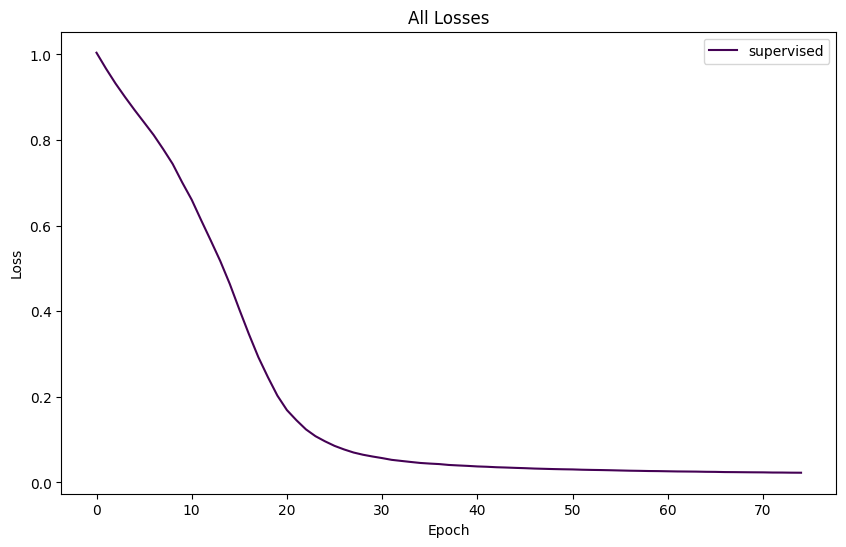

In [41]:
# Plot the losses
plot_losses(losses_supervised, False)

In [22]:
# train the generative parts of the network
losses_unsupervised = PITGAN_model.fit_unsupervised(train, 100)

---Starting Unsupervised Training
Epoch 0: Supervised Loss = 0.006840752903372049 Unsupervised Loss G = -0.23120100796222687 Unsupervised Loss C = 0.5680102109909058 Gradient Penalty = 0.0033308484125882387
Epoch 1: Supervised Loss = 0.0067716133780777454 Unsupervised Loss G = -0.10765904188156128 Unsupervised Loss C = 0.6251844763755798 Gradient Penalty = 0.0030090876389294863
Epoch 2: Supervised Loss = 0.0073482622392475605 Unsupervised Loss G = 0.0061313919723033905 Unsupervised Loss C = 0.6372358202934265 Gradient Penalty = 0.0029812154825776815
Epoch 3: Supervised Loss = 0.006967216730117798 Unsupervised Loss G = 0.11638271808624268 Unsupervised Loss C = 0.5947898030281067 Gradient Penalty = 0.0027334673795849085
Epoch 4: Supervised Loss = 0.00763595150783658 Unsupervised Loss G = 0.26526984572410583 Unsupervised Loss C = 0.5511243939399719 Gradient Penalty = 0.0038740227464586496
Epoch 5: Supervised Loss = 0.007787862326949835 Unsupervised Loss G = 0.39310669898986816 Unsupervise

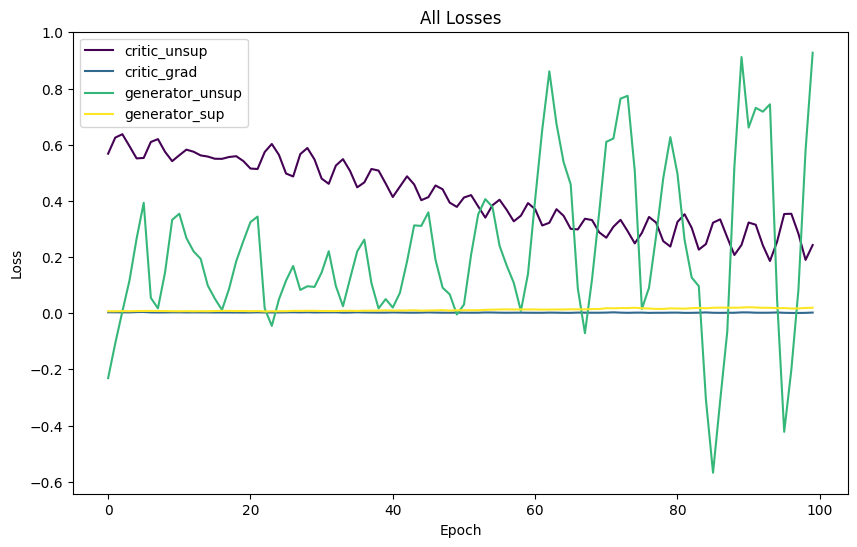

In [23]:
# Plot the losses
plot_losses(losses_unsupervised, False)

Now that the model has been trained we are able to start running inferences on it. First we retransform the data back to the form we can use. Then we plot it in comparison to the real data.

In [15]:
generated = PITGAN_model.generate(train, 1)

Y = PITGAN_model.get_latent(train, True)

Y = pd.DataFrame(Y)

Y_hat = PITGAN_model.get_latent(generated, True)

Y_hat = pd.DataFrame(Y_hat)

In [ ]:
Y

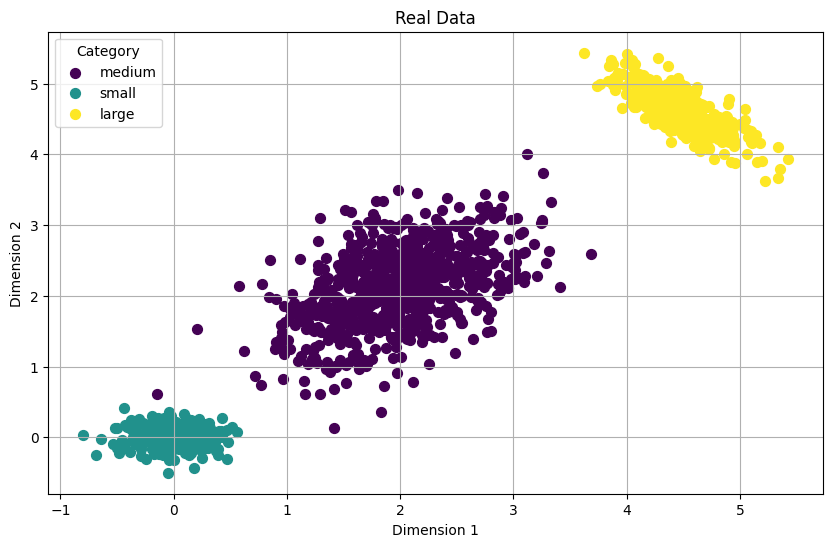

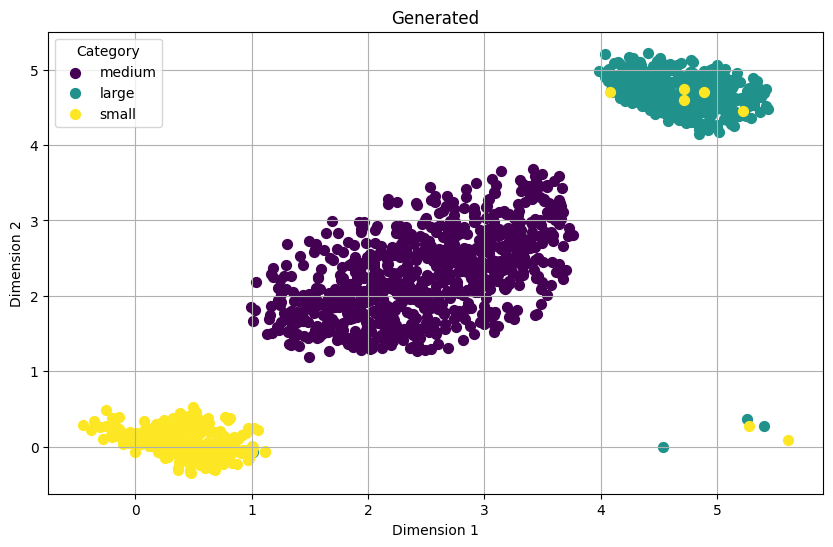

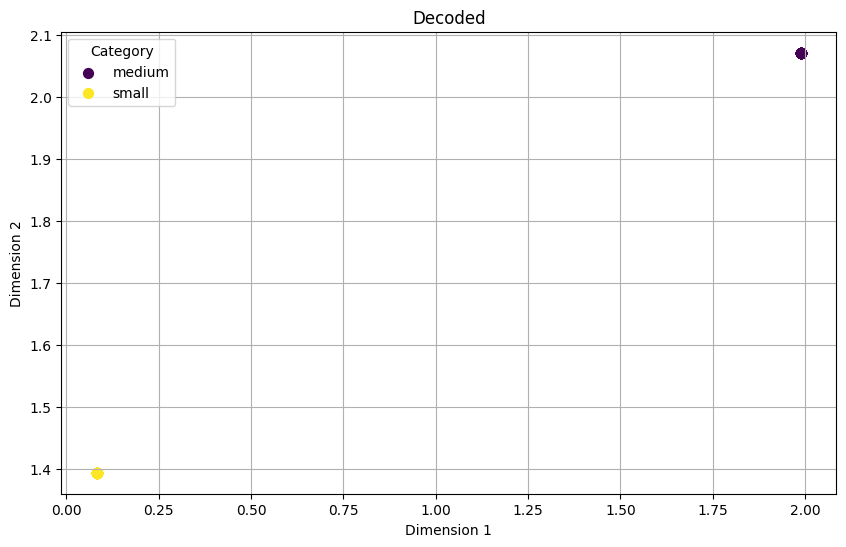

In [24]:
# plot the real data
plot_2D_data(train, 'Real Data')

generated = PITGAN_model.generate(train, 1)

# plot the generated data
plot_2D_data(generated, "Generated")

decoded = PITGAN_model.get_decoded(train)

# plot the decoded data
plot_2D_data(decoded, 'Decoded')

In [25]:
from evaluation.evaluation_procedure import evaluate
from visualizations.scatter_plots import plot_priv_utility

regressions = {
    'Dim_1': (['Dimension_1'],['Dimension_2'],['Category']),
    'Dim_2': (['Dimension_2'],['Dimension_1'],['Category'])
}

results = evaluate(train, PITGAN_model, basic_transformer, ['Category'], [0.33,0.33,0.33], [['Category']], regressions)

results

c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  synth_group = data_synth.groupby(keys + [target]).size().reset_index(name='count_synth')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  real_group = data_real.groupby(keys + [target]).size().reset_index(name='count_real')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:28: F

,Latent_dim,Decoded_ROC,ROC,CIO,pMSE,PMSE4,Utility,1-keys_TCAP,1-keys_TCAP_raw,1-keys_TCAP_real,1-keys_TCAP_raw_real
0,1,0.377967,0.90742,0.0,0.113145,0.547421,0.480098,0.993571,958.142624,0.993598,958.149474


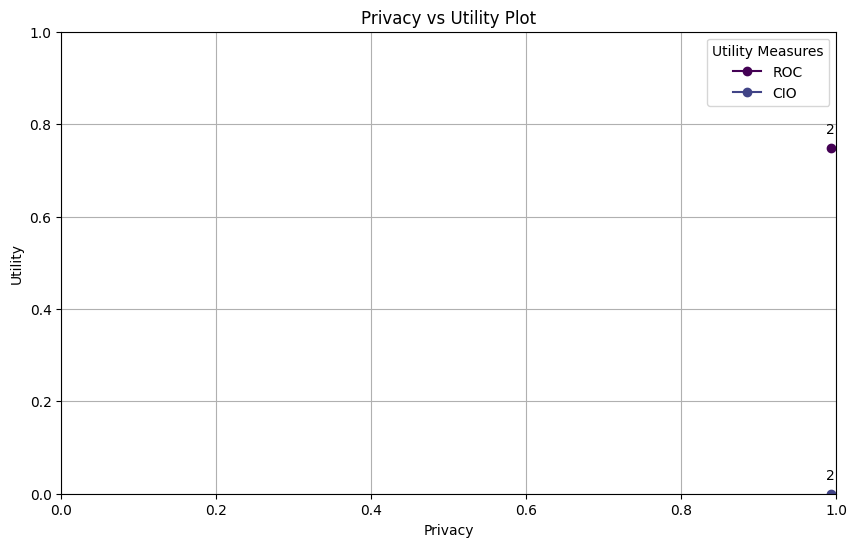

In [14]:
from visualizations.scatter_plots import plot_priv_utility_new

plot_priv_utility_new(results, False, '1-keys', ['ROC','CIO'])

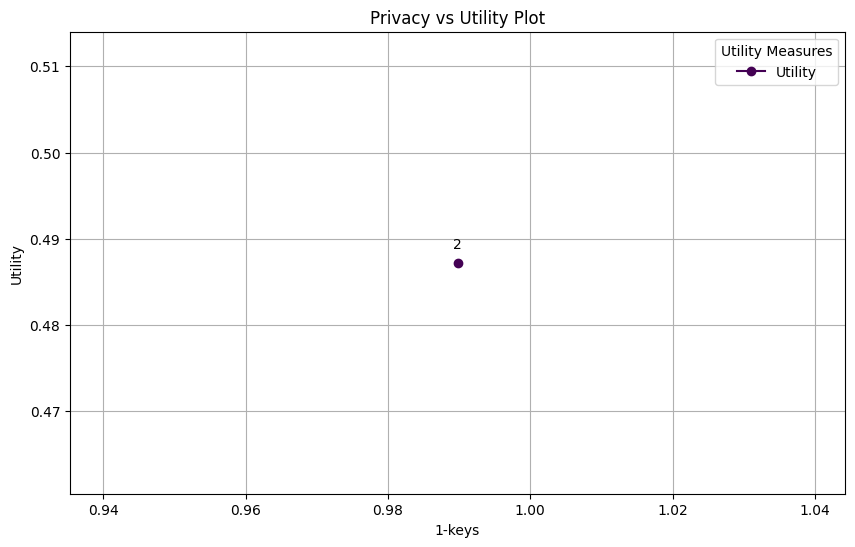

In [13]:
plot_priv_utility(results, True, '1-keys', ['ROC','CIO'])

Next Run the same model but without the latent space

In [196]:
ROC = compute_ROC(train, generated, basic_transformer)

CIO = compute_CIO(train, generated, ['Dimension_1'], ['Dimension_2'], [ 'Category'])

TCAP = compute_TCAP(train, generated, [['Category']], basic_transformer, 0.95)

pMSE = compute_pMSE(train, generated, ['Category'])

c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  synth_group = data_synth.groupby(keys + [target]).size().reset_index(name='count_synth')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  real_group = data_real.groupby(keys + [target]).size().reset_index(name='count_real')
c:\Users\olsda\OneDrive\Documents\NU classes\Year 4\MMSS Thesis\PITGAN Implenetation\Code\evaluation\privacy.py:23: F

In [202]:
# Specify the regressions to be sued for CIO evaluation
regressions = {
    'Dim_1': (['Dimension_1'],['Dimension_2'],['Category']),
    'Dim_2': (['Dimension_2'],['Dimension_1'],['Category'])
}

CIOs = compute_CIO_folds(train, PITGAN_model, regressions, 5)

CIOs

,Regression,Variable,CIO
0,Dim_1,const,0.167069
1,Dim_1,Dimension_2,0.036515
2,Dim_1,Category_medium,0.112069
3,Dim_1,Category_small,0.045196
4,Dim_2,const,0.036248
5,Dim_2,Dimension_1,0.352291
6,Dim_2,Category_medium,0.119225
7,Dim_2,Category_small,0.249848


In [197]:
CIO

,Variable,CIO
0,const,0.256554
1,Dimension_2,0.078086
2,Category_medium,0.136617
3,Category_small,0.043286


In [15]:
TCAP = compute_TCAP(train, generated, [['Category']], basic_transformer, 0.95)

TCAP

,Variable,TCAP,Num_Keys
0,C_1,0.577296,1-keys
1,C_2,0.979499,1-keys


Next check how the evaluation metrics are working